In [16]:
import pandas as pd
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, train_test_split

In [17]:
import xgboost as xgb
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error

In [18]:
# Set options
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

data_raw = pd.read_csv("STAT_444_project_data_power_transformed_noNA.csv", low_memory = True)

data_raw.reset_index(drop=True, inplace=True)
split_index = int(0.9 * len(data_raw))  # 80% for training, 20% for testing
train_raw = data_raw[:split_index] 
test_raw = data_raw[split_index:]


#train_x_raw = pd.read_csv("../01-Data/X_train.csv", low_memory = True, index_col=0)
#train_y_raw = pd.read_csv("../01-Data/y_train.csv", low_memory = True, index_col=0)
#test_x_raw = pd.read_csv("../01-Data/X_test.csv", low_memory=True, index_col=0)

df_train = pd.DataFrame(train_raw).drop(["date_1","date_2", "temp2_c", "temp2_min_c",
            "wind_speed50_ave_m_s", "max_generation_mw"], axis=1)
df_test = pd.DataFrame(test_raw).drop(["date_1","date_2", "temp2_c", "temp2_min_c",
            "wind_speed50_ave_m_s", "max_generation_mw"], axis=1)

In [19]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm

In [20]:
df_z_scaled = df_train.copy()
df_tz = df_test.copy()
# apply normalization techniques 
for column in df_z_scaled.columns:
    df_z_scaled[column] = df_z_scaled[column].astype(float)
    df_z_scaled[column] = (df_z_scaled[column] -
                           df_z_scaled[column].mean()) / (df_z_scaled[column].std())

for column in df_tz.columns:
    df_tz[column] = df_tz[column].astype(float)
    df_tz[column] = (df_tz[column] -
                           df_tz[column].mean()) / (df_tz[column].std())
df_z_scaled = df_z_scaled.dropna()
df_tz = df_tz.dropna()

In [21]:
df_xtrain = df_z_scaled.drop(['total_demand_mw'], axis=1)
df_xtest = df_tz.drop(['total_demand_mw'], axis=1)
df_ytrain = df_z_scaled['total_demand_mw']
df_ytest = df_tz['total_demand_mw']



In [22]:
def xgb_cv(max_depth, learning_rate, subsample, colsample_bytree, lambd, alpha, min_child_weight, gamma, scale_pos_weight, n_estimators):
    params = {
        'device': 'cuda:0',
        'objective': 'reg:squarederror',
        'max_depth': int(max_depth),
        'learning_rate': learning_rate,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'lambda': lambd,
        'alpha': alpha,
        'min_child_weight': min_child_weight,
        'gamma': gamma,
        'scale_pos_weight': scale_pos_weight
        #'n_estimators': int(n_estimators) #Comment this line out; you don't need it.
    }
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mse_scores = []
    #dtrain = xgb.DMatrix(df_xtrain, label = df_ytrain)
    #cv_result = xgb.cv(params, dtrain, num_boost_round=int(n_estimators), early_stopping_rounds=10, nfold=5, metrics='rmse') #  <---- you need to set the number of estimators here and accept it as an arg to the function.
    #return -cv_result['test-rmse-mean'].iloc[-1]
    for train_index, test_index in kf.split(df_xtrain,df_ytrain):
        xgb_train = xgb.DMatrix(df_xtrain.iloc[train_index], label=df_ytrain.iloc[train_index])
        xgb_valid = xgb.DMatrix(df_xtrain.iloc[test_index], label=df_ytrain.iloc[test_index])
        
        watchlist = [(xgb_train, 'train'), (xgb_valid, 'eval')]

        # Add early_stopping_rounds
        model = xgb.train(params, xgb_train, num_boost_round=500, evals=watchlist, early_stopping_rounds=10, verbose_eval=False)

        # Predict using the best iteration
        preds = model.predict(xgb_valid)
        #preds = model.predict(xgb_valid, ntree_limit=(model.best_iteration + 1) * params['num_class']

        mse_score = mean_squared_error(df_ytrain.iloc[test_index], preds)
        mse_scores.append(mse_score)

    return -np.mean(mse_scores)

pbounds = {
    'max_depth': (3, 9),
    'learning_rate': (0.01, 0.5),
    'subsample': (0.1, 1),
    'colsample_bytree': (0.1, 1),
    'lambd': (0.5, 4),
    'alpha': (0, 0.5),
    'min_child_weight': (2, 10),
    'gamma': (0.1, 0.5),
    'scale_pos_weight': (1, 1),
    'n_estimators': (50, 500) # <---- You need to indicate the number of trees here
}

optimizer = BayesianOptimization(f=xgb_cv, pbounds=pbounds, random_state=100)
optimizer.maximize(init_points=10, n_iter=300) 

|   iter    |  target   |   alpha   | colsam... |   gamma   |   lambd   | learni... | max_depth | min_ch... | n_esti... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------
| 1         | -0.1864   | 0.2717    | 0.3505    | 0.2698    | 3.457     | 0.01231   | 3.729     | 7.366     | 421.6     | 1.0       | 0.6176    |
| 2         | -0.2076   | 0.4457    | 0.2883    | 0.1741    | 0.8793    | 0.1177    | 8.872     | 8.493     | 127.4     | 1.0       | 0.3467    |
| 3         | -0.1848   | 0.2159    | 0.946     | 0.4271    | 1.676     | 0.09595   | 5.237     | 2.046     | 163.6     | 1.0       | 0.1137    |
| 4         | -0.162    | 0.2994    | 0.6434    | 0.1421    | 1.837     | 0.02787   | 8.342     | 9.847     | 76.97     | 1.0       | 0.6192    |
| 5         | -0.1591   | 0.3712    | 0.6672    | 0.3327    | 0.5715    | 0.1129    | 6.268     | 8.153     | 162.8     | 1.

In [23]:
optimizer.max['params']

{'alpha': 0.007316346579016753,
 'colsample_bytree': 1.0,
 'gamma': 0.19926358968824243,
 'lambd': 0.7137328462618535,
 'learning_rate': 0.04395792359841861,
 'max_depth': 8.945571211733691,
 'min_child_weight': 10.0,
 'n_estimators': 151.33528681899082,
 'scale_pos_weight': 1.0,
 'subsample': 0.8933497617206009}

In [25]:


# Best parameters from optimization
best_params = {
    'device': 'cuda:0',
    'max_depth': int(optimizer.max['params']['max_depth']),
    'gamma': optimizer.max['params']['gamma'],
    'colsample_bytree': optimizer.max['params']['colsample_bytree'],
    'subsample': optimizer.max['params']['subsample'],
    'learning_rate': optimizer.max['params']['learning_rate'],
    'lambda': optimizer.max['params']['lambd'],
    'alpha': optimizer.max['params']['alpha'],
    'min_child_weight': optimizer.max['params']['min_child_weight'],
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'verbosity': 0,
    'seed': 42
}

dtrain = xgb.DMatrix(df_xtrain, label=df_ytrain)
dval = xgb.DMatrix(df_xtest, label=df_ytest)

In [27]:
evals_result = {}
bst = xgb.train(best_params, dtrain, num_boost_round=1000, evals=[(dtrain, 'train'), (dval, 'val')],
                early_stopping_rounds=10, evals_result=evals_result, verbose_eval=True)

# Evaluate and print the final training and validation loss
train_last_eval = evals_result['train']['rmse'][-1]
val_last_eval = evals_result['val']['rmse'][-1]

print(f"Training MSE Loss: {train_last_eval**2}")
print(f"Validation MSE Loss: {val_last_eval**2}")

[0]	train-rmse:0.96333	val-rmse:0.98196


[1]	train-rmse:0.92819	val-rmse:0.97654
[2]	train-rmse:0.89520	val-rmse:0.97177
[3]	train-rmse:0.86322	val-rmse:0.96383
[4]	train-rmse:0.83307	val-rmse:0.95587
[5]	train-rmse:0.80415	val-rmse:0.95014
[6]	train-rmse:0.77669	val-rmse:0.94555
[7]	train-rmse:0.75027	val-rmse:0.94211
[8]	train-rmse:0.72537	val-rmse:0.93664
[9]	train-rmse:0.70185	val-rmse:0.93324
[10]	train-rmse:0.67923	val-rmse:0.93277
[11]	train-rmse:0.65775	val-rmse:0.92998
[12]	train-rmse:0.63751	val-rmse:0.93088
[13]	train-rmse:0.61790	val-rmse:0.92677
[14]	train-rmse:0.59937	val-rmse:0.91773
[15]	train-rmse:0.58148	val-rmse:0.91386
[16]	train-rmse:0.56508	val-rmse:0.90542
[17]	train-rmse:0.54886	val-rmse:0.90081
[18]	train-rmse:0.53334	val-rmse:0.89896
[19]	train-rmse:0.51824	val-rmse:0.89659
[20]	train-rmse:0.50439	val-rmse:0.89290
[21]	train-rmse:0.49128	val-rmse:0.89127
[22]	train-rmse:0.47876	val-rmse:0.88934
[23]	train-rmse:0.46687	val-rmse:0.89052
[24]	train-rmse:0.45539	val-rmse:0.88855
[25]	train-rmse:0.44462	v

In [30]:
mse_scores = []

dval = xgb.DMatrix(df_xtest, label=df_ytest)
dtrain = xgb.DMatrix(df_xtrain, label=df_ytrain)
watchlist=[(dtrain, 'train')]
model = xgb.train(best_params, dtrain, num_boost_round=500, evals=watchlist, early_stopping_rounds=10, verbose_eval=False)
 
        # Predict using the best iteration
preds = model.predict(dval)
        #preds = model.predict(xgb_valid, ntree_limit=(model.best_iteration + 1) * params['num_class']

mse_score = mean_squared_error(df_ytest, preds)
mse_scores.append(mse_score)
print(f'Loss: {np.mean(mse_scores)}')



Loss: 0.6571034679284505
[ 0.626285    0.5161747   0.5071619   0.5386308   0.601776    0.00758933
 -0.5603657  -0.4776909  -0.1781387   0.43063524 -0.0112024   0.08317566
  0.0033341   0.38273138  0.433178    0.3832026   0.10376962  0.0391102
  0.30722418  0.22392006  0.16382547  0.09925937  0.18422799  0.10493699
  0.13849887  0.16281064  0.05833681  0.09979166  0.11687435  0.0496698
 -0.03047008  0.07107269  0.11798795  0.0275309  -0.09418079 -0.08718422
 -0.12428577 -0.09812084  0.1306416  -0.15302521 -0.20815982 -0.06218387
 -0.03536819  0.13686977 -0.244306   -0.26504895 -0.14751469 -0.11494675
 -0.10085691 -0.10905845 -0.08748163 -0.08966813 -0.22546244 -0.13265555
 -0.09440723 -0.04395657 -0.08000039 -0.15297784 -0.2296323  -0.22740828
 -0.1225439  -0.1564136  -0.25715452 -0.21671411 -0.19502208 -0.21216159
 -0.07982352 -0.11779337 -0.15769231 -0.0636406  -0.25322697 -0.11825305
 -0.20555535 -0.21781273 -0.25325033 -0.01410426 -0.15957141 -0.08034379
 -0.1042174  -0.24615803 -0.

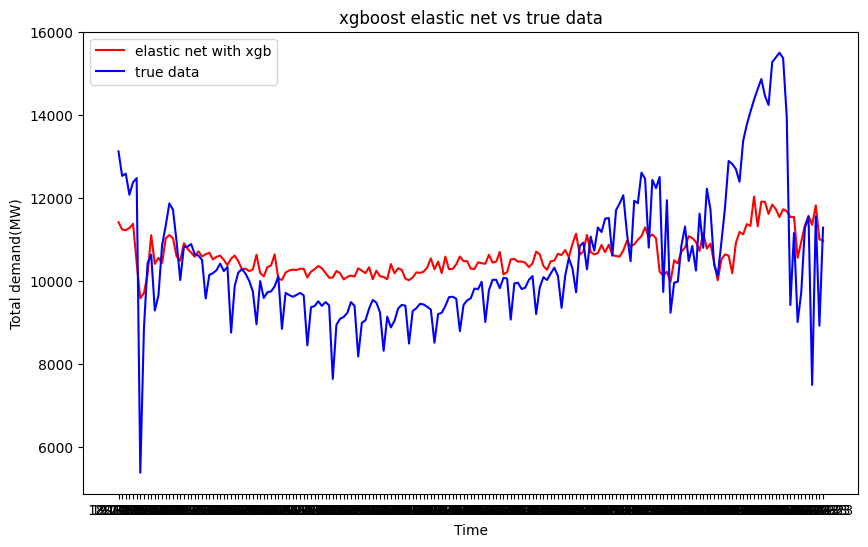

In [54]:
fig, ax = plt.subplots(figsize=(10, 6))
# Plot the first dataset
ax.plot(test_raw['date_1'], (preds*df_test["total_demand_mw"].std() + df_test["total_demand_mw"].mean())**2, label='elastic net with xgb', color='r')

# Plot the second dataset on the same axes
ax.plot(test_raw['date_1'], test_raw['total_demand_mw']**2, label='true data', color='b')

# Add a title and labels
ax.set_title('xgboost elastic net vs true data')
ax.set_xlabel('Time')
ax.set_ylabel('Total demand(MW)')

# Add a legend to differentiate the plots
ax.legend()

# Show the plot
plt.show()


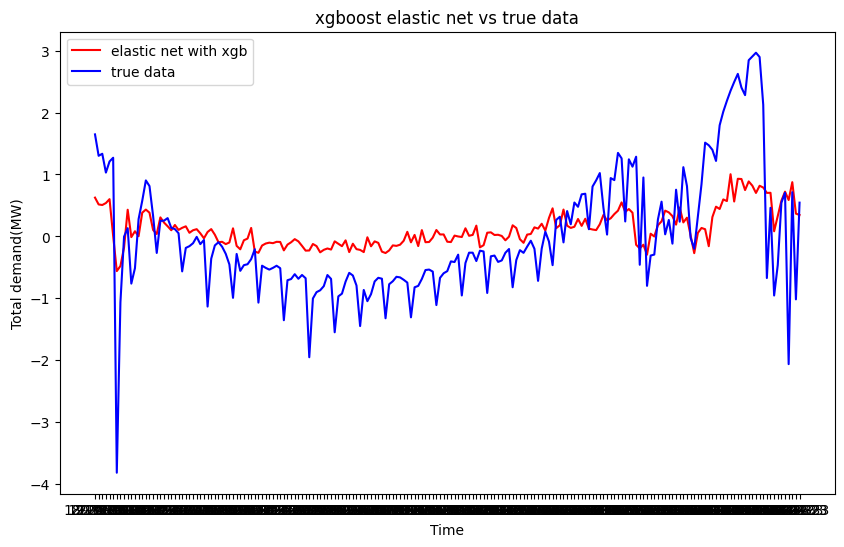

In [57]:
fig, ax = plt.subplots(figsize=(10, 6))
# Plot the first dataset
ax.plot(test_raw['date_1'], preds, label='elastic net with xgb', color='r')

# Plot the second dataset on the same axes
ax.plot(test_raw['date_1'], df_ytest, label='true data', color='b')

# Add a title and labels
ax.set_title('xgboost elastic net vs true data')
ax.set_xlabel('Time')
ax.set_ylabel('Total demand(MW)')

# Add a legend to differentiate the plots
ax.legend()

# Show the plot
plt.show()


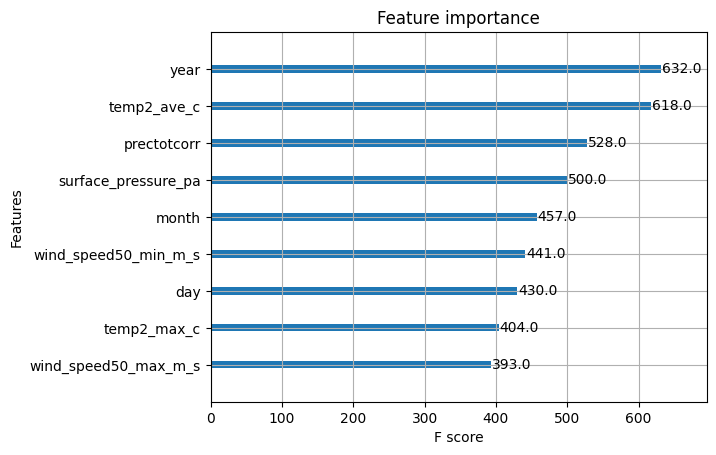

In [61]:
from xgboost import plot_importance
plot_importance(model)
plt.show()